# Security Onion Connections

## Import Python Modules

In [1]:
from elasticsearch import Elasticsearch
from elasticsearch_dsl import Q, Search
from IPython.display import HTML, display
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from pyvis.network import Network

### Suppress Certificate Warning for Self-Signed Cert

In [2]:
import urllib3
urllib3.disable_warnings(category=urllib3.exceptions.InsecureRequestWarning)

### Initialize Search Client

In [3]:
es = Elasticsearch(['https://172.20.2.10:9200'],
ca_certs=False,verify_certs=False, basic_auth=('jupyter','seconion'))
searchContext = Search(using=es, index='.ds-logs-*', doc_type='doc')

/opt/conda/lib/python3.11/site-packages/elasticsearch/_sync/client/__init__.py:400: SecurityWarning: Connecting to 'https://172.20.2.10:9200' using TLS with verify_certs=False is insecure
  _transport = transport_class(


### Prepare Search Query

In [4]:
q = Q('terms', tags=['conn']) & Q('range', **{'@timestamp': {'gte': 'now-24h', 'lt': 'now'}})
#f =
src = ('@timestamp', 'client.bytes', 'client.oui', 'client.ip', 'source.ip', 'source.port', 'destination.ip', 'destination.port', 'destination.geo.location.lat', 'destination.geo.location.lon')
s = searchContext.query(q).source(src)#.filter(f)

### Query and build dataset for connections

In [5]:
response = s.execute()
if response.success():
  df = pd.json_normalize([hit.to_dict() for hit in s.scan()])
#  df = pd.DataFrame(([d['event']['dataset'], d['process']['executable'], d['file']['target']] for d in s))
#  df = pd.DataFrame(([d['@timestamp'], d['destination']['port'], d['destination']['ip'], d['source']['port'], d['source']['ip'], d['client']['oui'], d['client']['bytes']] for d in s))
#  df.columns=['Dataset','Timestamp','Source.IP']
#  df = pd.DataFrame([d.to_dict() for d in s.scan()])
#df
#print(df)

## Quick Asset List

In [15]:
assets = pd.DataFrame(data=df, columns=['client.ip','client.oui'])
#display(HTML(assets.groupby(['client.oui']).size().reset_index(name='count').sort_values(by=['client.oui']).to_html(index=False)))
display(HTML(assets.drop_duplicates(subset=['client.ip']).sort_values(by=['client.oui']).to_html(index=False)))

client.ip,client.oui
fe80::acc:a7ff:fea9:67c0,"Cisco Systems, Inc"
fe80::ca4b:d6ff:fe93:2357,Dell Inc.
172.20.2.5,Dell Inc.
fd83:3cd:ed6b::8b0,Dell Inc.
fe80::3bc8:acfe:2b9d:a7f3,Dell Inc.
172.20.2.6,Dell Inc.
172.20.3.3,Dell Inc.
172.20.3.23,"Hui Zhou Gaoshengda Technology Co.,LTD"
fe80::1acf:b950:4695:9e39,"Hui Zhou Gaoshengda Technology Co.,LTD"
172.20.3.19,Intel Corporate


## Destination Heat Map

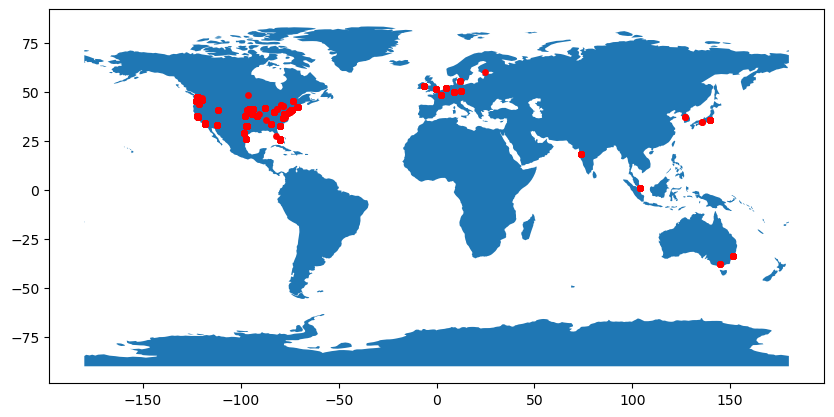

In [9]:
geo = pd.DataFrame(data=df, columns=['destination.geo.location.lat', 'destination.geo.location.lon'])
clean_geo = geo.dropna()

from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
import geodatasets

geometry = [Point(xy) for xy in zip(clean_geo['destination.geo.location.lon'], clean_geo['destination.geo.location.lat'])]
gdf = GeoDataFrame(clean_geo, geometry=geometry)   

#this is a simple map that goes with geopandas
# deprecated: world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = gpd.read_file(geodatasets.data.naturalearth.land['url'])
gdf.plot(ax=world.plot(figsize=(10, 6)), marker='o', color='red', markersize=15);

## Build a Node-Link Diagram

In [45]:
dst_ip = df['destination.ip']
src_ip = df['source.ip']
ip_concat = pd.concat([dst_ip, src_ip])
ip_set = ip_concat.drop_duplicates()
#ip_set

In [73]:
ip_conn = pd.DataFrame(data=df, columns=['destination.ip','source.ip'])
ip_weights = ip_conn.groupby(['destination.ip','source.ip']).size().reset_index(name='weight')
ip_edge = list(ip_weights.itertuples(index=False, name=None))
#ip_edge

In [82]:
G = nx.MultiDiGraph()
G.add_nodes_from(ip_set)
#G.nodes() 
G.add_weighted_edges_from(ip_edge)
#G.edges()

In [84]:
g = Network(height="700px", width="100%", notebook=True, select_menu=True, filter_menu=True, cdn_resources='remote')
g.from_nx(G)
#for node in g.get_nodes():
#    g.get_node(node)['physics']=False
g.toggle_hide_edges_on_drag(True)
g.toggle_physics(True)
g.barnes_hut()
g.show_buttons(filter_=['physics'])
g.save_graph('conn_last_24.html')